In [1]:
!pip install -q torch torchvision matplotlib scikit-learn seaborn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, random_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

100%|██████████| 170M/170M [00:03<00:00, 46.0MB/s]


In [6]:
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")

Training set size: 40000
Validation set size: 10000


In [7]:
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print(f"Test set size: {len(testset)}")

Test set size: 10000


In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
class MLPnet(nn.Module):
    def __init__(self, input_size=3*32*32, num_class=10):
        super(MLPnet, self).__init__()
        self.fc1 = nn.Linear(in_features = input_size, out_features=512)
        self.fc2 = nn.Linear(in_features = 512, out_features=512)
        self.fc3 = nn.Linear(in_features = 512, out_features=256)
        self.fc4 = nn.Linear(in_features = 256, out_features=256)
        self.fc5 = nn.Linear(in_features = 256, out_features=128)
        self.dropout = nn.Dropout(p=0.7)
        self.fc_last = nn.Linear(in_features = 128, out_features=num_class)
        self.auxil = nn.Linear(in_features = 512, out_features=num_class)
        self.batchnorm = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = torch.flatten(x, 1)
        first = self.batchnorm(F.gelu(self.fc1(x)))
        second = self.batchnorm(F.gelu(self.fc2(first))) + first
        third = self.batchnorm2(F.gelu(self.fc3(second)))
        fourth = self.batchnorm2(F.gelu(self.fc4(third))) + third
        x = self.batchnorm3(F.gelu(self.fc5(fourth)))
        x = self.dropout(x)
        out = self.fc_last(x)
        out_auxil = self.auxil(second)
        return out, out_auxil


In [14]:
def train_validate_model(model, model_name, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay_val=1e-5, aux_loss_weight=0.4):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_val)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\nBắt đầu huấn luyện cho {model_name}...")

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            if isinstance(outputs, tuple):
                outputs_main, outputs_aux = outputs
                loss_main = criterion(outputs_main, labels)
                loss_aux = criterion(outputs_aux, labels)
                loss = loss_main + aux_loss_weight * loss_aux


                _, predicted = torch.max(outputs_main.data, 1)
            else:
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % (len(train_loader) // 2) == 0 and i > 0:

                print(f'{model_name} - Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss Batch Hiện Tại: {loss.item():.4f}')

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)


        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

                outputs_val = model(inputs_val)

                if isinstance(outputs_val, tuple):
                    outputs_main_val, _ = outputs_val
                    loss_v = criterion(outputs_main_val, labels_val)
                    _, predicted_val = torch.max(outputs_main_val.data, 1)
                else:
                    loss_v = criterion(outputs_val, labels_val)
                    _, predicted_val = torch.max(outputs_val.data, 1)

                running_val_loss += loss_v.item() * inputs_val.size(0)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"{model_name} - Epoch [{epoch + 1}/{num_epochs}]: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    print(f"Hoàn thành huấn luyện cho {model_name}.")
    return history

In [ ]:

def test_model(model, test_loader, device, criterion=None): 
    model.eval()  
    all_preds = []
    all_labels = []
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if isinstance(outputs, tuple):
                outputs_main = outputs[0]
            else:
                outputs_main = outputs

            if criterion:
                loss = criterion(outputs_main, labels)
                running_test_loss += loss.item() * inputs.size(0)


            _, predicted = torch.max(outputs_main.data, 1)

            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct_test / total_test
    print(f"Test Accuracy: {test_acc:.4f}")

    if criterion:
        avg_test_loss = running_test_loss / len(test_loader.dataset)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        return test_acc, avg_test_loss, all_labels, all_preds
    else:
        return test_acc, all_labels, all_preds

def plot_learning_curves(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.suptitle(f'Learning Curves for {model_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

def plot_confusion_matrix_func(all_labels, all_preds, class_names, model_name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()


MLP Model with Dropout (p=0.7):
MLPnet(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_last): Linear(in_features=128, out_features=10, bias=True)
  (auxil): Linear(in_features=512, out_features=10, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Bắt đầu huấn luyện cho MLP_Dropout(p=0.7)...
MLP_Dropout(p=0.7) - Epoch [1/10], Step [156/313], Loss Batch Hiện Tại: 2.5995
MLP_Dropout(p=0.7) - Epoch [1/10], Step [312/313], Loss Batch

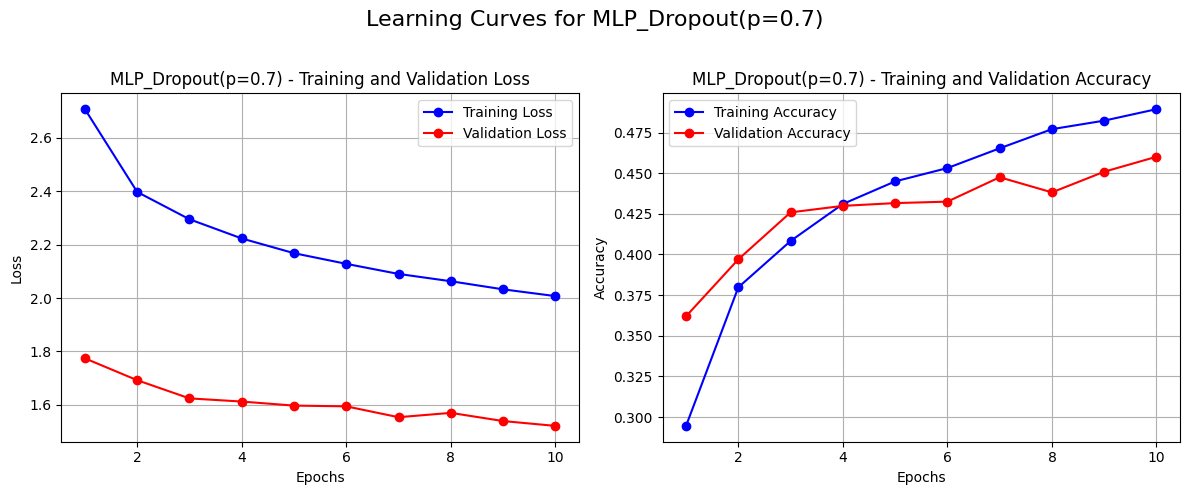

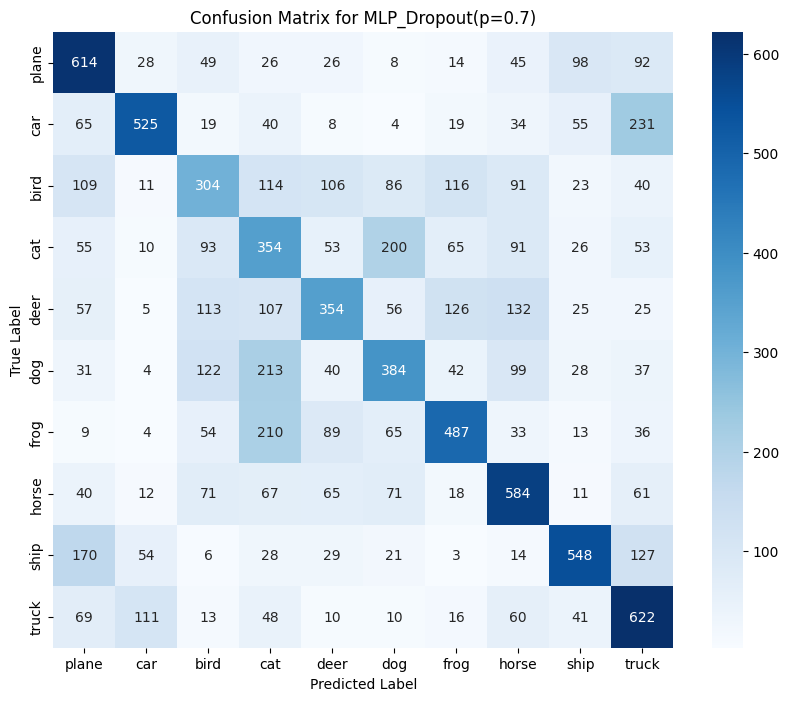

In [17]:

num_epochs_mlp = 10
mlp_dropout_prob = 0.7
mlp_model_dropout = MLPnet().to(device)
print(f"MLP Model with Dropout (p={mlp_dropout_prob}):\n{mlp_model_dropout}")

mlp_history_dropout = train_validate_model(mlp_model_dropout, f"MLP_Dropout(p={mlp_dropout_prob})", trainloader, valloader, device, num_epochs=num_epochs_mlp)

mlp_test_acc_dropout, mlp_labels_dropout, mlp_preds_dropout = test_model(mlp_model_dropout, testloader, device)
plot_learning_curves(mlp_history_dropout, f"MLP_Dropout(p={mlp_dropout_prob})")
plot_confusion_matrix_func(mlp_labels_dropout, mlp_preds_dropout, classes, f"MLP_Dropout(p={mlp_dropout_prob})")